# Working with individual files

In `0-preliminaries.ipynb` we searched NASA's archive for Sentinel-1 backscatter imagery and saved a list of URLS. Let's now start working with a single file! 

Contents:

* [GDAL](#GDAL-command-line-tools)
    * [Subsetting](#subsetting)
    * [reprojection](#reprojection)
* [Visualization](#visualization)
    * [rasterio](#rasterio)
    * [xarray+holoviz](#xarray-and-holoviz)
    * [save subset](#save-subset)

### GDAL command line tools

The [Geospatial Data Abstraction Library (GDAL)](https://gdal.org/) is foundational geospatial software that can be used to transform between formats, projections, and perform many common analysis tasks. GDAL has the ability to interact with 'Network based file systems' using an interface that transforms local file system operations to network requests, simply by prefixing the path to a file with `/vsicurl`. Read more in the [documentation](https://gdal.org/user/virtual_file_systems.html#vsicurl-http-https-ftp-files-random-access), but this is best illustrated with a simple example:

In [1]:
import os

In [2]:
with open('gamma0.txt', 'r') as f:
    gammas = [line.rstrip() for line in f]

In [3]:
print(f'{gammas[0]}\n...\n{gammas[-1]}')

https://n5eil11u.ecs.nsidc.org/TS1/DP0/MEASURES/NSIDC-0723.199/2020.07.27/GL_S1bks_mosaic_27Jul20_01Aug20_gamma0_50m_v03.1
...
https://n5eil11u.ecs.nsidc.org/TS1/DP0/MEASURES/NSIDC-0723.199/2020.09.25/GL_S1bks_mosaic_25Sep20_30Sep20_gamma0_50m_v03.1


In [4]:
# It turns out GDAL Needs some environment variables set for authentication and efficiency
# which get set here in front of the `gdalinfo` command
env_vars = 'GDAL_DISABLE_READDIR_ON_OPEN=EMPTY_DIR GDAL_HTTP_COOKIEFILE=.urs_cookies GDAL_HTTP_COOKIEJAR=.urs_cookies'
cog = gammas[-1]
cmd = f'{env_vars} gdalinfo /vsicurl/{cog} -approx_stats'
print(cmd)

GDAL_DISABLE_READDIR_ON_OPEN=EMPTY_DIR GDAL_HTTP_COOKIEFILE=.urs_cookies GDAL_HTTP_COOKIEJAR=.urs_cookies gdalinfo /vsicurl/https://n5eil11u.ecs.nsidc.org/TS1/DP0/MEASURES/NSIDC-0723.199/2020.09.25/GL_S1bks_mosaic_25Sep20_30Sep20_gamma0_50m_v03.1 -approx_stats


In [5]:
%%time

!{cmd}

Driver: GTiff/GeoTIFF
Files: /vsicurl/https://n5eil11u.ecs.nsidc.org/TS1/DP0/MEASURES/NSIDC-0723.199/2020.09.25/GL_S1bks_mosaic_25Sep20_30Sep20_gamma0_50m_v03.1
Size is 29520, 53220
Coordinate System is:
PROJCRS["WGS 84 / NSIDC Sea Ice Polar Stereographic North",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["US NSIDC Sea Ice polar stereographic north",
        METHOD["Polar Stereographic (variant B)",
            ID["EPSG",9829]],
        PARAMETER["Latitude of standard parallel",70,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8832]],
        PARAMETER["Longitude of origin",-45,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8833]],
        PARAMETER["False easting",0,
            LENGTHUNI

### Subsetting

Neat! While that particular file is big (29520x53220 pixels, over 1 Gigabyte on disk) but getting information about the projection and approximate statistics took a couple seconds. We have not downloaded anything, we are just streaming the metadata into memory. What if we'd like to download only a portion of this file rather than the whole thing? We can do this with `gdal_translate`:

In [8]:
bounding_box = '-54.85,69.31,-52.18,70.26' #West, South, East, North longitude and latitude bounds
ulx,uly,lrx,lry = [-54.85, 70.26, -52.18, 69.31]
src_dataset =  f'/vsicurl/{cog}'
filename = os.path.basename(cog)
dst_dataset = filename.replace('.1', '_subset.tif')
cmd = f'{env_vars} gdal_translate -projwin_srs EPSG:4326 -projwin {ulx} {uly} {lrx} {lry} {src_dataset} {dst_dataset}'
print(cmd)

GDAL_DISABLE_READDIR_ON_OPEN=EMPTY_DIR GDAL_HTTP_COOKIEFILE=.urs_cookies GDAL_HTTP_COOKIEJAR=.urs_cookies gdal_translate -projwin_srs EPSG:4326 -projwin -54.85 70.26 -52.18 69.31 /vsicurl/https://n5eil11u.ecs.nsidc.org/TS1/DP0/MEASURES/NSIDC-0723.199/2020.09.25/GL_S1bks_mosaic_25Sep20_30Sep20_gamma0_50m_v03.1 GL_S1bks_mosaic_25Sep20_30Sep20_gamma0_50m_v03_subset.tif


In [9]:
%%time 

!{cmd}

Input file size is 29520, 53220
0...10...20...30...40...50...60...70...80...90...100 - done.
CPU times: user 62.2 ms, sys: 26.2 ms, total: 88.4 ms
Wall time: 2.88 s


In [10]:
# Great! That only took a few seconds :) And now we can work with this local file that is of managble size
# NOTE that we no longer need the special environment variables for reading remote NASA data
cmd = f'gdalinfo {dst_dataset} -stats'
print(cmd)

gdalinfo GL_S1bks_mosaic_25Sep20_30Sep20_gamma0_50m_v03_subset.tif -stats


In [11]:
%%time 

!{cmd}

Driver: GTiff/GeoTIFF
Files: GL_S1bks_mosaic_25Sep20_30Sep20_gamma0_50m_v03_subset.tif
Size is 1725, 2402
Coordinate System is:
PROJCRS["WGS 84 / NSIDC Sea Ice Polar Stereographic North",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["US NSIDC Sea Ice polar stereographic north",
        METHOD["Polar Stereographic (variant B)",
            ID["EPSG",9829]],
        PARAMETER["Latitude of standard parallel",70,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8832]],
        PARAMETER["Longitude of origin",-45,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8833]],
        PARAMETER["False easting",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["False northin

### Reprojection

So far we've keep the file in its original coordinate reference system [EPSG:3413](https://epsg.io/3413), or "Polar Stereographic North". Perhaps you want to work with unprojected latitude longitude coordinates [EPSG:4326](https://epsg.io/4326). You can use `gdalwarp` to reproject this subset on the fly and save it locally:

In [12]:
# note target extent -te has different coordinate ordering compared to the earlier -projwin option
dstfile = dst_dataset.replace('.tif','.wgs84.tif')
cmd = f'{env_vars} gdalwarp -overwrite -t_srs EPSG:4326 -te {ulx} {lry} {lrx} {uly} {src_dataset} {dstfile}'
print(cmd)

GDAL_DISABLE_READDIR_ON_OPEN=EMPTY_DIR GDAL_HTTP_COOKIEFILE=.urs_cookies GDAL_HTTP_COOKIEJAR=.urs_cookies gdalwarp -overwrite -t_srs EPSG:4326 -te -54.85 69.31 -52.18 70.26 /vsicurl/https://n5eil11u.ecs.nsidc.org/TS1/DP0/MEASURES/NSIDC-0723.199/2020.09.25/GL_S1bks_mosaic_25Sep20_30Sep20_gamma0_50m_v03.1 GL_S1bks_mosaic_25Sep20_30Sep20_gamma0_50m_v03_subset.wgs84.tif


In [13]:
%%time 
!{cmd}

Creating output file that is 2682P x 954L.
Processing /vsicurl/https://n5eil11u.ecs.nsidc.org/TS1/DP0/MEASURES/NSIDC-0723.199/2020.09.25/GL_S1bks_mosaic_25Sep20_30Sep20_gamma0_50m_v03.1 [1/1] : 0Using internal nodata values (e.g. -30) for image /vsicurl/https://n5eil11u.ecs.nsidc.org/TS1/DP0/MEASURES/NSIDC-0723.199/2020.09.25/GL_S1bks_mosaic_25Sep20_30Sep20_gamma0_50m_v03.1.
Copying nodata values from source /vsicurl/https://n5eil11u.ecs.nsidc.org/TS1/DP0/MEASURES/NSIDC-0723.199/2020.09.25/GL_S1bks_mosaic_25Sep20_30Sep20_gamma0_50m_v03.1 to destination GL_S1bks_mosaic_25Sep20_30Sep20_gamma0_50m_v03_subset.wgs84.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
CPU times: user 63.3 ms, sys: 28.1 ms, total: 91.4 ms
Wall time: 2.98 s


In [14]:
!gdalinfo {dstfile}

Driver: GTiff/GeoTIFF
Files: GL_S1bks_mosaic_25Sep20_30Sep20_gamma0_50m_v03_subset.wgs84.tif
Size is 2682, 954
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-54.850000000000001,70.260000000000005)
Pixel Size = (0.000995525727069,-0.000995807127883)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( -54.8500000,  70.2600000) ( 54d51' 0.00"W, 70d15'36.00"N)
Lower Left  ( -54.8500000,  69.3100000) ( 54d51' 0.00"W, 

## Visualization

So far we have not visualized any of these images! GDAL is great for command line operations and batch processing, but not visualizing results. 

In [15]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'figure.figsize': (8.5,11)})

### Rasterio

There are many options in Python. We'll start with [`rasterio`](https://rasterio.readthedocs.io/en/latest/) a fantastic library that provides an intuitive Pythonic interface to GDAL and includes some convenience functions for plotting

In [16]:
# Open the JPG overview with Rasterio and plot
import rasterio
import rasterio.plot

# Rasterio uses an environment context manager for GDAL environment variables
Env = rasterio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                   GDAL_HTTP_COOKIEFILE='.urs_cookies',
                   GDAL_HTTP_COOKIEJAR='.urs_cookies')

In [18]:
# Accessing the Full-resolution data is also straightforward, no need for /vsicurl/
url = gammas[-1]
print(url)
title = os.path.basename(url)
with Env:
    with rasterio.open(url) as src:
        print(src.profile)  
        overview_factors = [src.overviews(i) for i in src.indexes][0]
        overview_levels = list(range(len(overview_factors)))
        print('Overview levels: ', overview_levels)
        print('Overview factors: ',  overview_factors) 

https://n5eil11u.ecs.nsidc.org/TS1/DP0/MEASURES/NSIDC-0723.199/2020.09.25/GL_S1bks_mosaic_25Sep20_30Sep20_gamma0_50m_v03.1
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -30.0, 'width': 29520, 'height': 53220, 'count': 1, 'crs': CRS.from_epsg(3413), 'transform': Affine(50.0, 0.0, -626000.0,
       0.0, -50.0, -695000.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
Overview levels:  [0, 1, 2, 3, 4, 5, 6]
Overview factors:  [2, 4, 8, 16, 32, 64, 128]


In [19]:
# NOTE from above that overview_level=0 downsamples full-resolution by a factor of 2:
with Env:
    with rasterio.open(url, OVERVIEW_LEVEL=0) as src:
        print(src.profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -30.0, 'width': 14760, 'height': 26610, 'count': 1, 'crs': CRS.from_epsg(3413), 'transform': Affine(100.0, 0.0, -626000.0,
       0.0, -100.0, -695000.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -30.0, 'width': 462, 'height': 832, 'count': 1, 'crs': CRS.from_epsg(3413), 'transform': Affine(3194.805194805195, 0.0, -626000.0,
       0.0, -3198.3173076923076, -695000.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


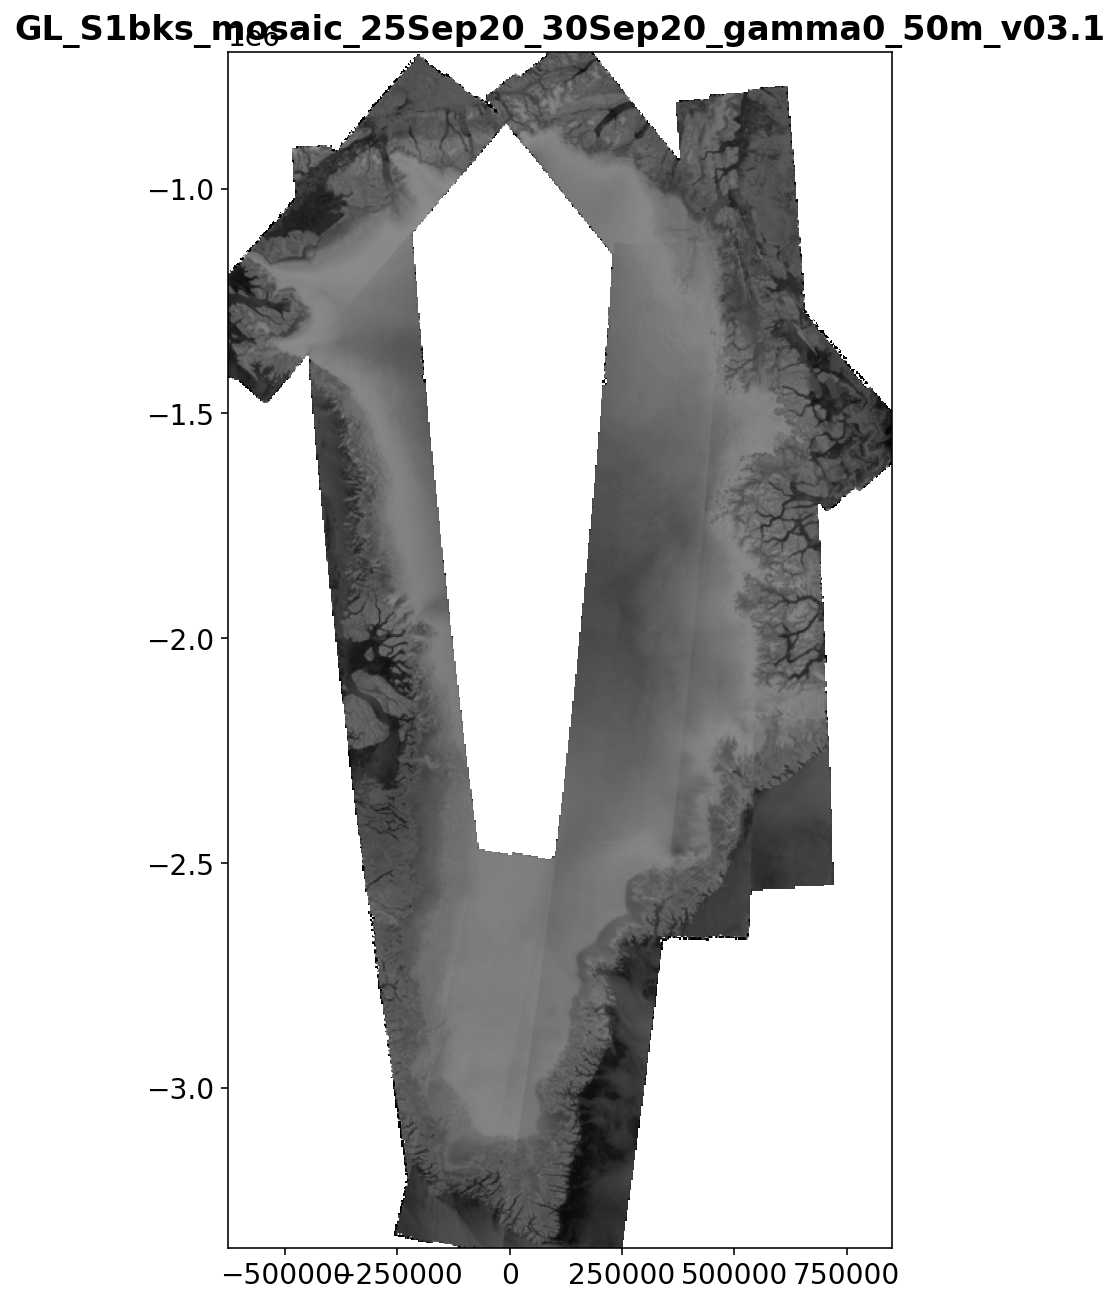

CPU times: user 332 ms, sys: 53.9 ms, total: 386 ms
Wall time: 388 ms


In [26]:
%%time 

# Plot lowest resolution overview
with Env:
    with rasterio.open(url, OVERVIEW_LEVEL=5) as src:
        print(src.profile)
        rasterio.plot.show(src, cmap='gray', title=title, vmin=-30, vmax=30)

### Xarray and Holoviz

Again, there are many ways to accomplish this in Python, but we'll demonstrate a particularly powerful combination for geospatial analysis. [RioXarray](https://github.com/corteva/rioxarray) combines Xarray + Rasterio for analysis of multidimensional geospatial data. [Holoviz](https://holoviz.org/) combines various Python plotting libraries for interactive visualization in a webbrowser

In [21]:
import rioxarray as rx
import hvplot.xarray

In [22]:
# An alternative to using rasterio.Env() is to set global environment variables:
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR'
os.environ['GDAL_HTTP_COOKIEFILE']='.urs_cookies' 
os.environ['GDAL_HTTP_COOKIEJAR']='.urs_cookies'

In [23]:
%%time

da = rx.open_rasterio(url, overview_level=4, masked=True).squeeze('band') #Read an overview and account for NoDATA value
da

CPU times: user 58.8 ms, sys: 5.25 ms, total: 64 ms
Wall time: 65.2 ms


<xarray.DataArray (y: 1664, x: 923)>
[1535872 values with dtype=float64]
Coordinates:
    band         int64 1
  * y            (y) float64 -6.958e+05 -6.974e+05 ... -3.354e+06 -3.355e+06
  * x            (x) float64 -6.252e+05 -6.236e+05 ... 8.476e+05 8.492e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

In [25]:
# Note this plot is interactive! You'll see coordinate and pixel values as you move the cursor, resolution updates as you zoom in
da.hvplot.image(rasterize=True, dynamic=True, aspect='equal', frame_width=200, cmap='gray',
                title=title, clim=(-30,30))

:DynamicMap   []
   :Image   [x,y]   (value)

In [27]:
# Read a subset window at full resolution
da = rx.open_rasterio(url, masked=True).squeeze('band') 

# Use pixel coordinates
subset = da.isel(x=slice(int(1e4),int(1.5e4)), y=slice(int(1e3),int(2e3)))
subset.hvplot.image(rasterize=True, dynamic=True, frame_width=400, cmap='gray')

:DynamicMap   []
   :Image   [x,y]   (value)

In [28]:
# USE EPSG:4313 coordinates (left->right, top->bottom)
subset = da.sel(x=slice(-1.0e5, 1.0e5), y=slice(-7.5e5, -7.9e5))
subset.hvplot.image(rasterize=True, dynamic=True, frame_width=400, cmap='gray')

:DynamicMap   []
   :Image   [x,y]   (value)

In [29]:
# Reproject a small piece (preferred, more control over warp resampling, etc, dataset easier to reference)
subset4326 = subset.rio.reproject('EPSG:4326') 
subset4326.hvplot.image(rasterize=True, dynamic=True, frame_width=400, cmap='gray')

:DynamicMap   []
   :Image   [x,y]   (value)

In [30]:
# Use Basemap tiles (these are usually in a given projection to begin with)
subset4326.hvplot.image(geo=True, tiles=True, 
                         rasterize=True, dynamic=True, frame_width=400, frame_height=400, cmap='gray')

:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [x,y]   (value)

### Save subset

Finally, we may want to save this subset we've been working with for future use 

In [31]:
%%time

subset.rio.to_raster('mysubset.tif', dtype='float32', driver='GTiff', COMPRESS='LZW', NUM_THREADS=4)

CPU times: user 184 ms, sys: 43.9 ms, total: 228 ms
Wall time: 108 ms


In [32]:
# Round trip test
subset = rx.open_rasterio('mysubset.tif', masked=True)
subset

<xarray.DataArray (band: 1, y: 800, x: 4000)>
[3200000 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 -7.5e+05 -7.501e+05 ... -7.899e+05 -7.9e+05
  * x            (x) float64 -9.998e+04 -9.992e+04 ... 9.992e+04 9.998e+04
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref